### Import des packages et données utiles

In [1]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.io.cif import CifWriter
from pymatgen.ext.matproj import MPRester
import matplotlib.pyplot as plt

In [2]:
mp_key = "7T8Rm9ppE58YHsBs2IkJCMwMXshrwbpx"
mp_id = "mp-1018096"

In [3]:
prim_struc = MPRester(mp_key).get_structure_by_material_id(mp_id)
conv_struc = SpacegroupAnalyzer(prim_struc).get_conventional_standard_structure()

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

### Hypothèses de départ

Dans l'analyse du diffractogramme ci-dessous, nous admettrons les hypothèses suivantes :

    1. la diffusion est élastique;
    2. la diffusion est simple;
    3. la source est située à l’infini;
    4. le détecteur est situé à l’infini;
    5. le détecteur mesure une intensité (pas une amplitude).
Les hypothèses 3 et 4 nous permettent d'approximer l'onde par une onde plane, ce qui va nous simplifier les calculs et l'analyse.

### Extraction des données à analyser

In [4]:
xrd = XRDCalculator(1.54060)
I_max = max(xrd.get_pattern(conv_struc,scaled=False).y)
print(f"I_max = {I_max} W/m^2")
pattern = xrd.get_pattern(conv_struc,scaled=True)

I_max = 14139133.8035955 W/m^2


Tout d'abord, nous récoltons l'intensité maximale des pics pour les mettres à l'échelle, c'est-à-dire faire en sorte que l'intensité maximale soit à 100. Donc $I_{échelle} = \frac{I}{I_{max}} \cdot 100$. $\newline$
Ensuite, nous stockons dans la variable pattern toutes les données relatives au diffractogramme.

### Analyse

L'angle $2\theta$ correspond à l'angle formé entre la direction d'incidence des rayons X et la direction d'observation. L'intensité relative a été introduite plus haut. Les indices $hkl$ sont les indices de Miller des plans contribuants aux pics de diffraction. Un quatrième indice, l'indice $i$, est introduit pour des raisons de symétrie. Il est donc redondant et est défini comme $i:=-(h+k)$. Les rayons X sont diffractés sur ces plans. La multiplicité désigne le nombre de plans équivalents. Quant à $d_{hkl}$, cette variable représente la distance entre deux plans (hkl) consécutifs du réseau. 
Ces données sont reprises via le code ci-dessous.

In [6]:
for i in range(3):
    print(f"Pic {i+1}: 2θ = {pattern.x[i]:.2f}°, Intensité (à l'échelle) = {pattern.y[i]:.1f}, hkil = {pattern.hkls[i][0]['hkl']},  Multiplicité = {pattern.hkls[i][0]['multiplicity']}, d_hkl = {pattern.d_hkls[i]}")

Pic 1: 2θ = 13.25°, Intensité (à l'échelle) = 3.2, hkil = (0, 0, 0, 3),  Multiplicité = 2, d_hkl = 6.675103140000086
Pic 2: 2θ = 25.95°, Intensité (à l'échelle) = 0.6, hkil = (1, 0, -1, 1),  Multiplicité = 12, d_hkl = 3.431336089243126
Pic 3: 2θ = 26.69°, Intensité (à l'échelle) = 27.5, hkil = (0, 0, 0, 6),  Multiplicité = 2, d_hkl = 3.337551570000043


Pour avoir un pic de diffraction, il faut que la condition de Bragg soit respectée :
$\begin{equation}
n \lambda = 2 d sin(\theta) 
\end{equation}$
où n est l'ordre de la réflexion, d la distance entre deux plans consécutifs et $\theta$ l'angle entre le rayon X incident et le plan où la diffraction se produit. Cette relation détermine la position des pics de Bragg dans le diffractogramme.$\newline$

Notons que la distance $d_{hkl}:=\frac{2\pi}{|\boldsymbol{K}|}$ où $\boldsymbol{K} := h\boldsymbol{a*} + k \boldsymbol{b*} + l \boldsymbol{c*}$ est un vecteur du réseau réciproque. Ce dernier est orthogonal au plan du réseau direct (hkl), puisqu'il appartient à la rangée $[hkl]$ du réseau réciproque$\newline$

Définissons $\boldsymbol{k} := \frac{2 \pi}{\lambda}\boldsymbol{\hat{n}}$, le vecteur d'onde du rayon incident. Faisons de même avec $\boldsymbol{k'} := \frac{2 \pi}{\lambda}\boldsymbol{\hat{n'}}$, le vecteur d'onde du rayon diffusé. Soit $\boldsymbol{R} := u\boldsymbol{a} + v\boldsymbol{b} + w \boldsymbol{c}$, avec $u,v,w$ entiers, un vecteur du réseau direct. La condition de Laue stipule que $e^{(\boldsymbol{k'}-\boldsymbol{k}) \cdot \boldsymbol{R}} = 1$ pour avoir un pic de diffraction. Autrement dit, $\boldsymbol{K} = \boldsymbol{k'}-\boldsymbol{k}$. Cette relation est équivalente à celle de Bragg. $\newline$

Le facteur de structure de maille est donné par $S_{\mathbf{K}} = \sum_{j=1}^{N} f_j(\mathbf{K}) e^{i \mathbf{K} \cdot \mathbf{r}_j}$ où $f_j(\mathbf{K})$ est le facteur de forme atomique et $\mathbf{r}_j$ une position d'un site diffuseur dans la maille (un atome, un ion, etc.). Il exprime dans quelle mesure l'interférence des ondes diffusées par les ions identiques à l'intérieur du motif peut diminuer l'intensité du pic de Bragg. Des facteurs de forme proches pour différents sites du cristal peuvent l'amoindrir de façon significative. Notons également que pour $2\theta =0$, $f_j= Z_j$ ($Z_j$ étant le nombre d'électrons de l'élément j) et les électrons diffusent en phase. Pour $2\theta \neq 0$, $f_j <Z_j$ et il existe un déphasage entre les rayons diffusés. Pour certains $\mathbf{K}$, $|S_{\mathbf{K}}| = 0$, on appelle cela une extinction systématique.$\newline$

La multiplicité d'un plan joue aussi un rôle dans l'intensité d'un pic, celle-ci lui étant proportionnelle.

Nous avons représenté les trois premiers pics du diffractogramme ci-dessous.

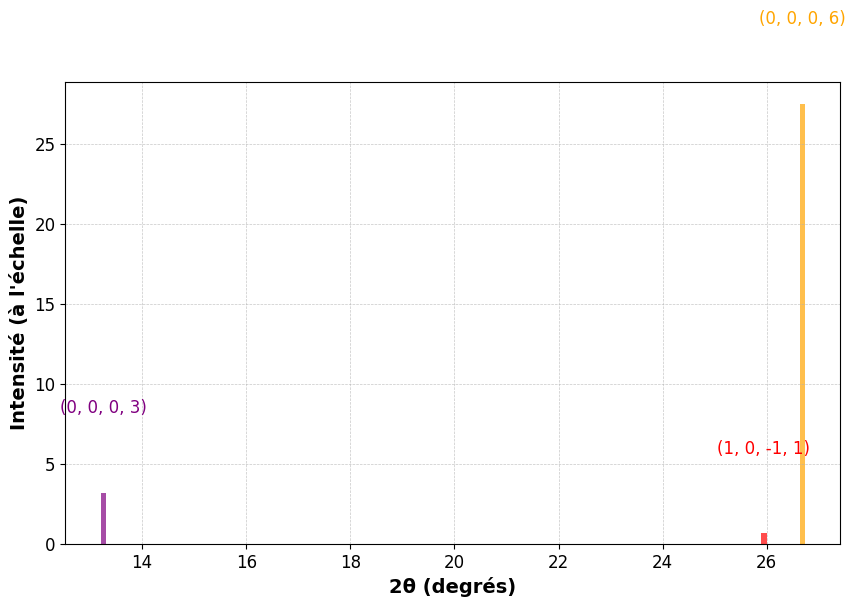

In [8]:
plt.figure(figsize=(10, 6))
colors = ['purple', 'red', 'orange'] + ['blue'] * (len(pattern.x) - 3)
plt.bar(pattern.x[:3], pattern.y[:3], width=0.1, color=colors, alpha=0.7)

for i in range(3):
    plt.text(pattern.x[i], pattern.y[i] + 5, f"{pattern.hkls[i][0]['hkl']}",
             fontsize=12, ha='center', color=colors[i], fontweight='normal')

plt.xlabel("2θ (degrés)", fontsize=14, fontweight='bold')
plt.ylabel("Intensité (à l'échelle)", fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()


Le premier pic se trouve en $2\theta = 13,25°$ avec une intensité relative de 3,2. Il est associé à la famille (0003) dont les plans sont séparés de 6,675103140000086 Å. Le deuxième, quant à lui, se situe en $2\theta = 25,95°$ avec une intensité relative de 0,6. Il correspond à une diffraction sur la famille de plan (10-11) interséparés de 3,431336089243126 Å. En $2\theta = 26,69°$, le troisième pic apparaît avec une intensité relative de 27,5. Il correspond à la famille (0006), dont les plans consécutifs sont séparés de 3,337551570000043 Å.

Nous pouvons remarquer que les deux premiers pics sont très petits par rapport au troisième. Cela peut s'expliquer par la différence des facteurs de structure de maille pour les indices (0003), (10-11) et (0006). On peut supposer que la multiplicité joue un rôle moins important, dans le sens où l'intensité est proportionnelle au carré du facteur de structure, contrairement à la multiplicité qui n'a qu'une proportionnalité linéaire.

### Bibliographie

[1] Université Catholique de Louvain (UCLouvan), *LMAPR1492*, 2025.

[2] B. D. Cullity and S. R. Stock, *Elements of X-Ray Diffraction*, 3rd ed., Pearson Education Limited, 2014. Pages consultées : 147 et 319. [Online]. Available: https://www.eng.uc.edu/~beaucag/Classes/AdvancedMaterialsThermodynamics/Books/B.D.%20Cullity,%20S.R.%20Stock%20-%20Elements%20of%20X-Ray%20Diffraction-Pearson%20Education%20Limited%20(2014).pdf. [Accessed: Mar. 15, 2025].

[3] *3.014 Materials Laboratory, Fall 2006*, Massachusetts Institute of Technology (MIT). [Online]. Available: https://ocw.mit.edu/courses/3-014-materials-laboratory-fall-2006/resources/w4_g2/. [Accessed: Mar. 15, 2025].
